In [ ]:
# Uncomment to install phasopy
!pip install phasorpy
!pip install cmcrameri

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 2.8 MB/s eta 0:00:00



# Synthesize signals from lifetimes

An introduction to the `lifetime_to_signal` function.

The :py:func:`phasorpy.phasor.lifetime_to_signal` function is used
to synthesize time- and frequency-domain signals as a function of
fundamental frequency, single or multiple lifetime components,
lifetime fractions, mean and background intensity, and instrument
response function (IRF) peak location and width.


Import required modules and functions:



In [ ]:
import numpy as np
from matplotlib import pyplot
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cmcrameri.cm as cmc

from phasorpy.phasor import (
    #lifetime_to_signal,
    #phasor_calibrate,
    #phasor_from_lifetime,
    phasor_from_signal,
)
from phasorpy.lifetime import phasor_from_lifetime, lifetime_to_signal, phasor_calibrate

Define common parameters used throughout the tutorial:



In [ ]:
## Temporal parameters
tau_1 = 1.6
tau_2 = 1.9
lifetimes = [tau_1, tau_2]  # lifetime in ns


frequency = 50.0  # fundamental frequency in MHz
period = (1 / frequency) * 1e3 # period of fundamental frequency in ns
reference_lifetime = 0.06  # lifetime of reference signal in ns


settings = {
    'samples': 256,  # number of samples to synthesize
    'mean': 10,  # average intensity
    'background': 0,  # no signal from background
    'zero_phase': 0.08,  # location of IRF peak in the phase
    'zero_stdev': None,  # standard deviation of IRF in radians
}

## Spatial parameters
pxsz = 5                                             # Pixel size in nm
# Optics
sigma_nm = 100                                       # PSF sigma in nanometers. Equvalent to a FWHM of 235 nm
sigma_px = int(sigma_nm / pxsz)                      # PSF sigma in pixels. Equvalent to a FWHM of 235 nm

# Image
x_dim = y_dim = 127                                  # Image Size in pixels
center = np.ceil(x_dim/2).astype(int)

cy = center


# Both fluorophores in the center
#cx_1 = center
#cx_2 = center

# MSSR limit distance
#cx_1 = int(center - 0.8 * sigma_px) #LEFT FLUOROPHORE
#cx_2 = int(center + 0.8 * sigma_px) #RIGHT FLUOROPHORE

# Sparrow limit distance
#cx_1 = center - sigma_px
#cx_2 = center + sigma_px

# Rayleigh limit distance
#cx_1 = int(center - 1.25 * sigma_px)
#cx_2 = int(center + 1.25 * sigma_px)

# 3s, No diffraction-limited distance
#cx_1 = int(center - 1.5 * sigma_px)
#cx_2 = int(center + 1.5 * sigma_px)

# 4s, No diffraction-limited distance
cx_1 = int(center - 2.0 * sigma_px)
cx_2 = int(center + 2.0 * sigma_px)

# 6s, No diffraction-limited distance
#cx_1 = int(center - 3.0 * sigma_px)
#cx_2 = int(center + 3.0 * sigma_px)


# Visualization
color = 'PRGn' #'cmc.batlowK'
title_size = 18
axtitles = 18
ticksize = 12
legendtitles = '16'


## Time-domain, single-exponential

To synthesize separate signals for each lifetime component at once,
omit the lifetime fractions:



In [ ]:
signal, _, times = lifetime_to_signal(frequency, lifetimes, **settings)
reference_signal, _, _ = lifetime_to_signal(frequency, reference_lifetime, **settings)
signal_1 = signal[0] #Fluorophore with tau_1 (1ns)
signal_2 = signal[1] #Fluorophore with tau_2 (4ns)

Plot the synthesized signal:



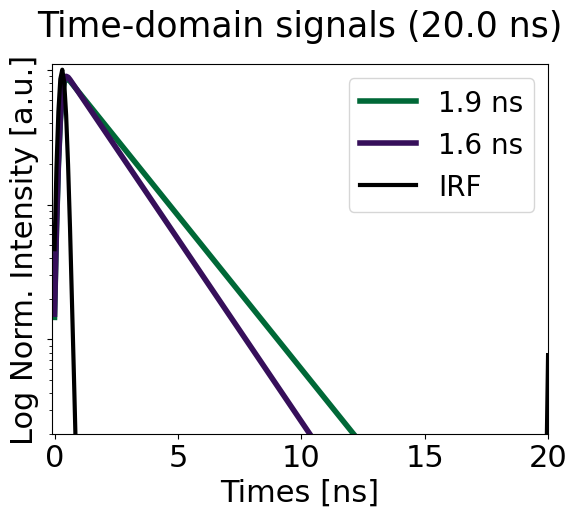

In [ ]:
purple = '#360f5a'
green = '#006837'
pink = 'mmm'
line = 4
irf_line = 3
legend = 20
title = 25
axistitle = 22
ticksize = 22

# Normalize signals to have a zero background

w = (2*np.pi) / period
mod_2 = 1 / np.sqrt((1 + (w*tau_2)**2))
mod_1 = 1 / np.sqrt((1 + (w*tau_1)**2))

#bl_signal_1 = signal_1 - np.min(signal_1)
#bl_signal_2 = signal_2 - np.min(signal_2)
#IRF -= np.min(IRF)

norm_signal_1 = signal_1 / np.max(signal_1) * mod_1
norm_signal_2 = signal_2 / np.max(signal_2) * mod_2

IRF = (reference_signal/np.max(reference_signal)) * np.max(signal)
IRF -= np.min(IRF)
norm_IRF = IRF / np.max(IRF)


#Plot figure

fig, ax = pyplot.subplots()
ax.set_title(f'Time-domain signals ({period} ns)', fontsize=title, pad = 20) # Set title fontsize
ax.set_xlabel('Times [ns]', fontsize=axistitle)  # Set x-axis label fontsize
ax.set_ylabel('Log Norm. Intensity [a.u.]', fontsize=axistitle)  # Set y-axis label fontsize
ax.plot(times, norm_signal_2, label= '{:.1f} ns'.format(tau_2), color = green, linewidth = line)
ax.plot(times, norm_signal_1, label= '{:.1f} ns'.format(tau_1), color = purple, linewidth = line)
ax.plot(times, norm_IRF, label='IRF', color = 'k', linewidth = irf_line)
ax.set_yscale('log')
ax.legend(fontsize = legend)
ax.set_xlim(-0.1, 20)
ax.set_ylim(0.002, 1.1)
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y',labelleft= False, labelsize=ticksize)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pyplot.show()

As expected, the shorter the lifetime, the faster the decay.



In [ ]:
from phasorpy.phasor import phasor_from_signal
from phasorpy.lifetime import phasor_calibrate
from phasorpy.plot import PhasorPlot

# Transform the synthetic signals to the phasor space
mean, real, imag = phasor_from_signal(signal)

# Synthesize reference signal from reference lifetime
reference_signal, _, _ = lifetime_to_signal(
    frequency, reference_lifetime, **settings
)

# Transform reference signal to phasor space
reference_mean, reference_real, reference_imag = phasor_from_signal(
    reference_signal)

# Calibrate phasor coordinates using reference
real, imag = phasor_calibrate(real, imag, reference_mean, reference_real, reference_imag,
                              frequency=frequency,
                              lifetime=reference_lifetime)

In [ ]:
reference_mean

array(10.)

/tmp/ipython-input-1658719181.py:7: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(times, reference_signal, label=[f'{t} ns' for t in lifetimes])


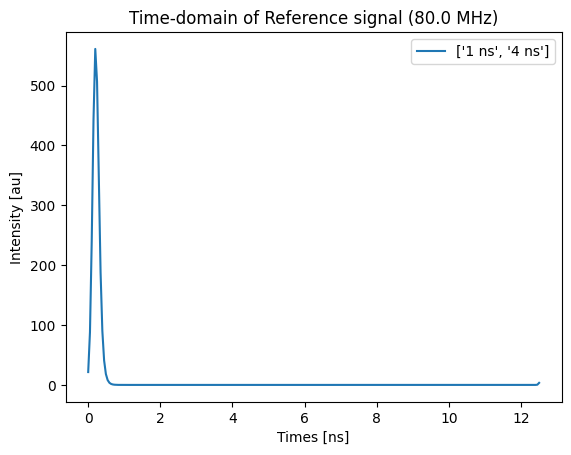

In [ ]:
fig, ax = pyplot.subplots()
ax.set(
    title=f'Time-domain of Reference signal ({frequency} MHz)',
    xlabel='Times [ns]',
    ylabel='Intensity [au]',
)
ax.plot(times, reference_signal, label=[f'{t} ns' for t in lifetimes])
ax.legend()
pyplot.show()

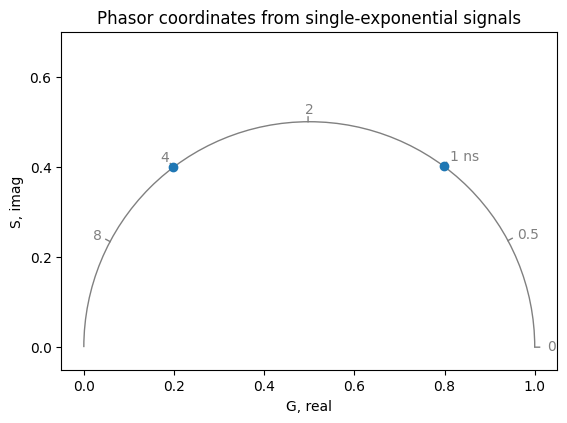

In [ ]:
# Plot calibrated phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Phasor coordinates from single-exponential signals')
  plot.plot(real, imag)
  plot.show()

## Create a TD emission stack with two fluorophores exhibiting different lifetimes.

(127, 127, 256)


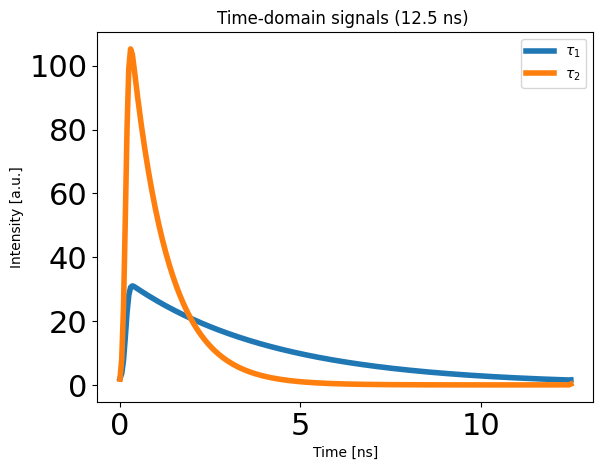

In [ ]:
##### create an TD emission x,y,t stack for each fluorophore
t_dim = settings['samples']
# Create fluorescence data stacks initialized to zero
F1xy = np.zeros((y_dim, x_dim, t_dim))
F2xy = np.zeros((y_dim, x_dim, t_dim))
F1xy[cy, cx_1, :] = signal.T[:,1]  # Left Fluorophore with tau_2 (4ns)
F2xy[cy, cx_2, :] = signal.T[:,0]  # Right Fluorophore with tau_1 (1ns)

print(F1xy.shape)

# Create figure and axis
fig, ax = plt.subplots()

# Define the title, labels, and formatting
ax.set(
    title=f'Time-domain signals ({period} ns) ',
    xlabel='Time [ns]',
    ylabel='Intensity [a.u.]',
)

# Plot fluorophore signals
ax.plot(times, F1xy[cy, cx_1, :], label='$\\tau_1$', linewidth = line)
ax.plot(times, F2xy[cy, cx_2, :], label='$\\tau_2$', linewidth = line)

# Customize ticks
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)

# Add legend
ax.legend(loc=1)

# Display the plot
plt.show()

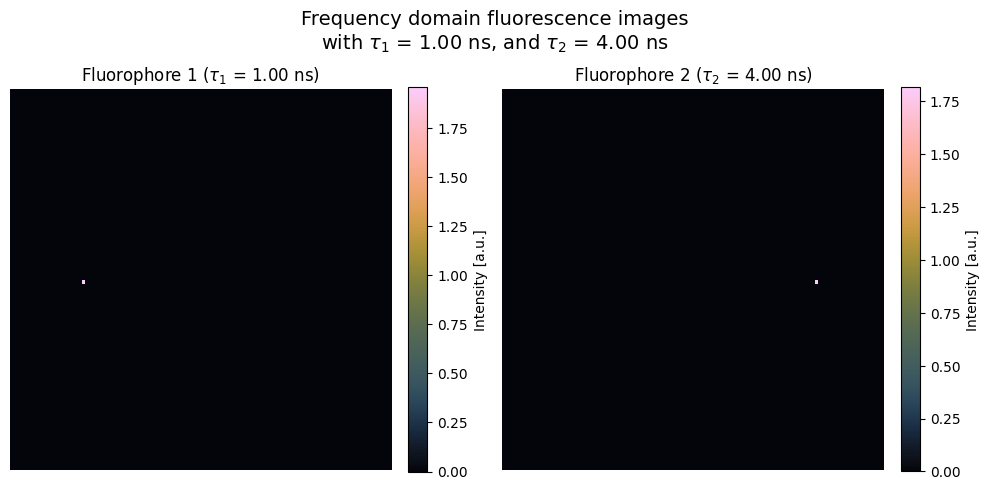

In [ ]:
# Create figure and axis
color = 'cmc.batlowK'
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Two side-by-side subplots

# Define titles using fluorophore lifetimes
title_1 = f'Fluorophore 1 ($\\tau_1$ = {tau_1:.2f} ns)'
title_2 = f'Fluorophore 2 ($\\tau_2$ = {tau_2:.2f} ns)'

# Plot F1xy (Frame 0) with raw intensities
im1 = axes[0].imshow(F1xy[:, :, 0], cmap=color)
axes[0].set_title(title_1)

# Plot F2xy (Frame 0) with raw intensities
im2 = axes[1].imshow(F2xy[:, :, 0], cmap=color)
axes[1].set_title(title_2)

# Add colorbars for both images
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Intensity [a.u.]")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Intensity [a.u.]")

# Remove axis ticks for better visualization
for ax in axes:
    ax.axis("off")

# Set overall figure title using fluorophore lifetimes
fig.suptitle(f'Frequency domain fluorescence images\nwith $\\tau_1$ = {tau_1:.2f} ns, and $\\tau_2$ = {tau_2:.2f} ns', fontsize=14)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

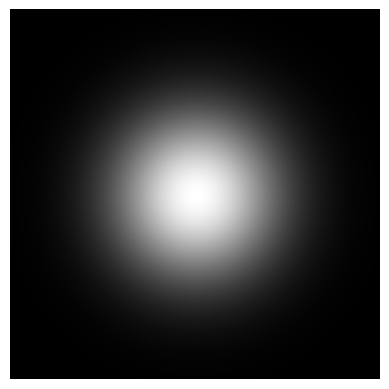

In [ ]:
import scipy.signal
# Create a Gaussian-like PSF
def gaussian_psf(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf /= np.sum(psf)  # Normalize PSF
    return psf

# Define PSF size and sigma
sigma_psf = sigma_px  # Standard deviation of PSF

# Generate PSF
PSF = gaussian_psf(x_dim, sigma_psf)
plt.axis('off')
plt.imshow(PSF, cmap="gray")
# Convolve each frame in the (x, y, t) stack
F1xy_convolved = np.empty_like(F1xy)
F2xy_convolved = np.empty_like(F2xy)

for t in range(t_dim):
    F1xy_convolved[:, :, t] = scipy.signal.fftconvolve(F1xy[:, :, t], PSF, mode='same')
    F2xy_convolved[:, :, t] = scipy.signal.fftconvolve(F2xy[:, :, t], PSF, mode='same')


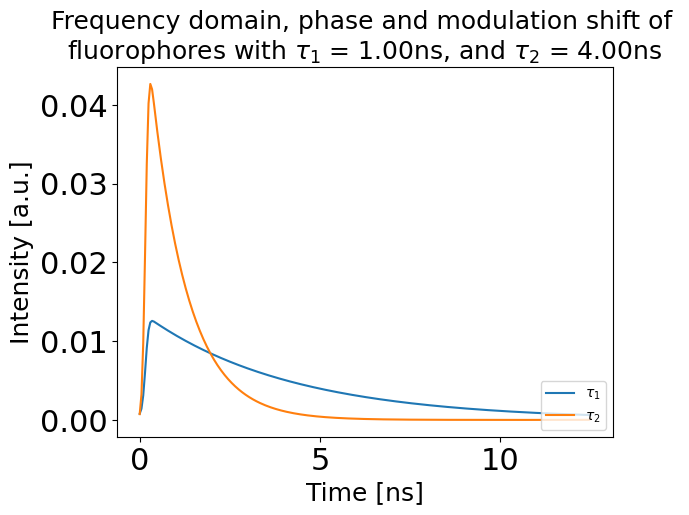

In [ ]:
#plt.plot(E_t, linestyle ='--', label = 'Excitation')
plt.plot(times, F1xy_convolved[cy, cx_1, :], label = '$\u03C4_1$')
plt.plot(times, F2xy_convolved[cy, cx_2, :], label = '$\u03C4_2$')
plt.title('Frequency domain, phase and modulation shift of \nfluorophores with $\u03c4_1$ = {:.2f}ns, and $\u03C4_2$ = {:.2f}ns'.format(tau_1, tau_2),  fontsize = title_size)
plt.xlabel('Time [ns]', fontsize = axtitles)
plt.ylabel('Intensity [a.u.]', fontsize = axtitles)
plt.tick_params(axis='x', labelsize = ticksize)
plt.tick_params(axis='y', labelsize = ticksize)
plt.legend(loc = 4)
plt.show()

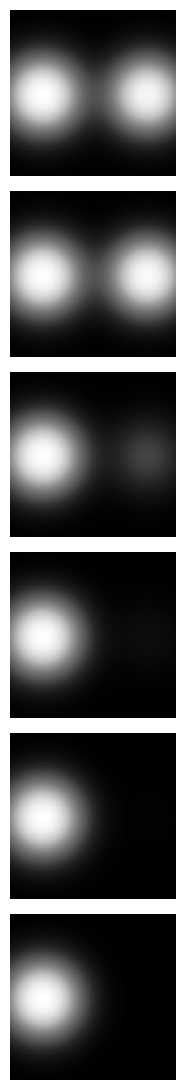

In [ ]:
fr = 6  # Fixed reference frame
step = 3  # Step size
times_to_display = [0, 2, 4, 6, 8, 10]  # Frames to display
# Find the closest index for each value in times_to_display
indices = [np.abs(times - t).argmin() for t in times_to_display]


# Create figure with 2x2 grid for four images
labelsize = 21
font = 22
color = 'Greys_r'
title = 16
weight = 'bold'
fig, axes = plt.subplots(6, 1 , figsize=(13, 11))

for ax, i in zip(axes.flat, indices):
    montage_frame = F1xy_convolved[:, :, i] + F2xy_convolved[:, :, i]
    norm_montage_frame = montage_frame / np.max(montage_frame)
    im = ax.imshow(norm_montage_frame, cmap=color) # Set intensity limits properly
    #ax.imshow(montage_frame, cmap="PRGn", zlim =c(1,3))  # Display image in grayscale
    #ax.set_title(f"Time = {round(times[i], 1)} ns", fontsize = title, pad = 5, fontweight = weight)
    ax.axis("off")  # Remove axes for cleaner visualization
    # Add colorbar for each subplot
    #cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.007, aspect = 12)
    #cbar.ax.tick_params(labelsize=labelsize)  # Optional: Adjust tick size
    # Set the colorbar title
    #cbar.set_label('Norm\nIntensity [a.u.]', fontsize=font) #fontweight='bold')

#cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.007, aspect = 12)
#cbar.ax.tick_params(labelsize=labelsize)  # Optional: Adjust tick size
# Set the colorbar title
#cbar.set_label('Intensity [a.u.]', fontsize=font) #fontweight='bold')
plt.tight_layout()
plt.show()

## Anlayse the modelled TD-FLIM signal

In [ ]:
print(reference_signal.shape)

## Synthesize a TD-FLIM reference signal, taking as an example a homogeneous solution of fluorescein with a lifetime of 4.2 ns.

In [ ]:
img_reference_signal = np.zeros((x_dim, y_dim, t_dim))

for x in range(img_reference_signal.shape[0]):  # Loop over x-dimension
    for y in range(img_reference_signal.shape[1]):  # Loop over y-dimension
        img_reference_signal[x, y, :] = reference_signal  # Assign time-domain signal

#assert reference_signal.attrs['frequency'] == frequency
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

from phasorpy.plot import plot_phasor_image
plot_phasor_image(
    img_reference_mean, img_reference_real, img_reference_imag, title='Reference TD-FLIM signal'
)


In [ ]:
from phasorpy.plot import plot_signal_image

plot_signal_image(img_reference_signal, title='Reference TD-FLIM signal')

In [ ]:
img_reference_real.shape

In [ ]:
img_reference_real

In [ ]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Callibration Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag)
  plot.show()

NameError: name 'PhasorPlot' is not defined

## Calibrate

In [ ]:
TD_FLIM_signal =F1xy_convolved + F2xy_convolved

#For 0s: mean_0s, real_0s, imag_0s
#mean_0s, real_0s, imag_0s = phasor_from_signal(TD_FLIM_signal, axis = 2)

#For MSSR: mean_MS, real_MS, imag_MS
#mean_MS, real_MS, imag_MS = phasor_from_signal(TD_FLIM_signal, axis = 2)

#For Sparrow: mean_spa, real_spa, imag_spa
mean_spa, real_spa, imag_spa = phasor_from_signal(TD_FLIM_signal, axis = 2)

#For Rayleigh: mean_ray, real_ray, imag_ray
#mean_ray, real_ray, imag_ray = phasor_from_signal(TD_FLIM_signal, axis = 2)

#For 3s: mean_3s, real_3s, imag_3s
#mean_3s, real_3s, imag_3s = phasor_from_signal(TD_FLIM_signal, axis = 2)

#For 4s: mean_4s, real_4s, imag_4s
#mean_4s, real_4s, imag_4s = phasor_from_signal(TD_FLIM_signal, axis = 2)

#For 6s: mean_6s, real_6s, imag_6s
#mean_6s, real_6s, imag_6s = phasor_from_signal(TD_FLIM_signal, axis = 2)


# Calibrate phasor for 0s coordinates using reference
#real_0s, imag_0s = phasor_calibrate(real_0s, imag_0s, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_0s, imag_0s, bins =85)

# Calibrate phasor for MSSR coordinates using reference
#real_MS, imag_MS = phasor_calibrate(real_MS, imag_MS, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_MS, imag_MS, bins =85)

# Calibrate phasor for Sparrow coordinates using reference
real_spa, imag_spa = phasor_calibrate(real_spa, imag_spa, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_spa, imag_spa, bins =85)

# Calibrate phasor for Rayleigh coordinates using reference
#real_ray, imag_ray = phasor_calibrate(real_ray, imag_ray, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_ray, imag_ray, bins =85)

# Calibrate phasor for 3s coordinates using reference
#real_3s, imag_3s = phasor_calibrate(real_3s, imag_3s, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_3s, imag_3s, bins =85)

# Calibrate phasor for 4s coordinates using reference
#real_4s, imag_4s = phasor_calibrate(real_4s, imag_4s, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_4s, imag_4s, bins =85)

# Calibrate phasor for 6s coordinates using reference
#real_6s, imag_6s = phasor_calibrate(real_6s, imag_6s, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_6s, imag_6s, bins =85)

NameError: name 'F1xy_convolved' is not defined

In [ ]:
from phasorpy.plot import plot_phasor_image

#plot_phasor_image(mean_0s, real_0s, imag_0s)

In [ ]:
from phasorpy.phasor import phasor_threshold

color = 'Blues'
color_2 = 'PRGn'
#Threshold for 0s
#mean_th_0s, real_th_0s, imag_th_0s = phasor_threshold(mean_0s, real_0s, imag_0s, mean_min=0.001)
#plot_phasor_image(mean_th_0s, real_th_0s, imag_th_0s, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_0s, imag_th_0s, bins = 75, cmap=color_2)

#Threshold for MSSR
#mean_th_MS, real_th_MS, imag_th_MS = phasor_threshold(mean_MS, real_MS, imag_MS, mean_min=0.001)
#plot_phasor_image(mean_th_MS, real_th_MS, imag_th_MS, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_MS, imag_th_MS, bins = 75, cmap=color)

#Threshold for Sparrow
mean_th_spa, real_th_spa, imag_th_spa = phasor_threshold(mean_spa, real_spa, imag_spa, mean_min=0.001)
plot_phasor_image(mean_th_spa, real_th_spa, imag_th_spa)#, title='TD-FLIM of two fluorophores\n at the Sparrow Limit')
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_spa, imag_th_spa, bins = 100)

#Threshold for Rayleigh
#mean_th_ray, real_th_ray, imag_th_ray = phasor_threshold(mean_ray, real_ray, imag_ray, mean_min=0.001)
#plot_phasor_image(mean_th_ray, real_th_ray, imag_th_ray, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_ray, imag_th_ray, bins = 85)

#Threshold for 3s
#mean_th_3s, real_th_3s, imag_th_3s = phasor_threshold(mean_3s, real_3s, imag_3s, mean_min=0.001)
#plot_phasor_image(mean_th_3s, real_th_3s, imag_th_3s, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_3s, imag_th_3s, bins = 75, cmap=color)

#Threshold for 4s
#mean_th_4s, real_th_4s, imag_th_4s = phasor_threshold(mean_4s, real_4s, imag_4s, mean_min=0.001)
#plot_phasor_image(mean_th_4s, real_th_4s, imag_th_4s, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_4s, imag_th_4s, bins = 75, cmap=color)

#Threshold for 6s
#mean_th_6s, real_th_6s, imag_th_6s = phasor_threshold(mean_6s, real_6s, imag_6s, mean_min=0.001)
#plot_phasor_image(mean_th_6s, real_th_6s, imag_th_6s, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_6s, imag_th_6s, bins = 75, cmap=color)

NameError: name 'mean_spa' is not defined

In [ ]:
T = (1 / frequency) * 1e3
print(T)

# TD-FL image (lifetime maps) from Phasor coordinates #

In [ ]:
def td_flim_figure(G,S,laser_period_in_seconds, harmonic = 1, mod_correction = True, mod_lower_limit = 0.1, phase_correction = True, phase_lower_limit = 0.1, tau_m_correction = True, factor_tm = 1, tau_p_correction = True, factor_tp = 1, num_bins = 100, color = color):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation, phase delay, modulation lifetimes and phase lifetimes
    #i.e. the TD-FLIM image it also contaains the instructions for plotting the results
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano
    # Setting epsilon to avoid division by zero
    epsilon = np.nan

    G = np.where(G > 0, G, epsilon)
    S = np.where(S > 0, S, epsilon)

    mod = np.sqrt(G**2 + S**2)
    phi = np.arctan2(S,G)

    mod_min = 1 / np.sqrt((1 + (w_nano*tau_2)**2))
    mod_max = 1 / np.sqrt((1 + (w_nano*tau_1)**2))

    phi_max = np.arctan(w_nano*tau_2)
    phi_min = np.arctan(w_nano*tau_1)

    #Corrections
    #Mod correction
    if mod_correction:
        mod = np.where(mod >= mod_lower_limit, mod, epsilon)

    tau_m = (1 / w) * np.sqrt(np.maximum((1/(mod**2))-1,0))
    tau_m = tau_m*1e9   #to show in nanoseconds

    #Phase correction
    quarter_pi = np.arctan(1)
    phi[phi==quarter_pi] = epsilon

    if phase_correction:
        upper_limit = np.min([np.pi - phase_lower_limit, np.max(phi)-np.max(phi) * 0.01])  # Define your upper threshold
        phi = np.where((phase_lower_limit <= phi) & (phi <= upper_limit), phi, epsilon)

    tau_p = (1 / w) * (np.tan(phi))
    tau_p = tau_p*1e9       #to show in nanoseconds

    #tau_p correction
    if tau_p_correction:
        tau_p = np.where(tau_p <= (T_nano/factor_tp), tau_p, epsilon)
        tau_p_label = f'Phase Lifetime [ns] (/{factor_tp})'
    else:
        tau_p[tau_p > T_nano] = epsilon
        tau_p_label = 'Phase Lifetime [ns]'

    #tau_mod correction
    if tau_m_correction:
        tau_m = np.where(tau_m <= (T_nano/factor_tm), tau_m, epsilon)
        tau_m_label = f'Modulation Lifetime [ns] (/{factor_tm})'
    else:
        tau_m[tau_m > T_nano] = epsilon
        tau_m_label = 'Modulation Lifetime [ns]'

    # G and S correction
    if mod_correction or phase_correction:
        G_corr = mod * np.cos(phi)
        S_corr = mod * np.sin(phi)

    elif tau_m_correction or tau_p_correction:
        w_nano = (2 * np.pi) / T_nano
        G_corr = np.sqrt(1 / (((w_nano * tau_m)**2 + 1) * ((w_nano * tau_p)**2 + 1)))
        G_corr = np.where(G_corr < 1, G_corr, epsilon)
        S_corr = w_nano * tau_p * G_corr

    else:
        G_corr = G
        S_corr = S


    #Output figure

    color = color
    titlesize = 16
    suptitle = 18
    axsize = 14
    ticksize = 12

    if not np.array_equal(G_corr, G) or not np.array_equal(S_corr, S):
        ##   Contour for the phasor plot   ##
        x = np.linspace(-1.0, 1.0, 100)
        y = np.linspace(-1.0, 1.0, 100)
        X, Y = np.meshgrid(x, y)
        F = X ** 2 + Y ** 2 - X

        ##Images of TD_FLIM and the phasor plot
        f, ax = plt.subplots(2,3, figsize = (14,8))

        #Modulation Map
        im00 = ax[0,0].imshow(mod, cmap=color, vmin = mod_min, vmax= mod_max)
        # Scatter plots
        ax[0,0].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350, label = 'position of $\u03c4_1$')
        ax[0,0].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350, label = 'position of $\u03c4_2$')
        ax[0,0].axis('off')
        ax[0,0].set_title('Modulation Map', fontsize=titlesize)
        cbar00 = f.colorbar(im00, ax = ax[0,0], fraction=0.046, pad=0.04)
        #l = np.linspace(0.0, 1, 6)
        #cbar00.set_ticks(l)
        cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar00.set_label('Modulation [a.u.]', fontsize=axsize)
        cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        ax[0,0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2
        #ax[0,0].set_box_aspect(1)

        #Phase Map
        im01 = ax[0,1].imshow(phi, cmap=color, vmin= phi_min, vmax=phi_max)
        # Scatter plots
        ax[0,1].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350)
        ax[0,1].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350)
        ax[0,1].axis('off')
        ax[0,1].set_title('Phase Map', fontsize=titlesize)
        cbar01 = f.colorbar(im01, ax = ax[0,1], fraction=0.046, pad=0.04)
        #a = np.linspace(0.0, np.max(phi), 6)
        #cbar01.set_ticks(a)
        cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar01.set_label('Phase angle [rad]', fontsize=axsize)
        cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[0,1].set_box_aspect(1)

        #Tau_m Map
        im10 = ax[1,0].imshow(tau_m, cmap=color, vmin = tau_1, vmax=tau_2)
        # Scatter plots
        ax[1,0].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350)
        ax[1,0].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350)
        ax[1,0].axis('off')
        ax[1,0].set_title('Modulation Lifetime, $\u03c4_M$', fontsize=titlesize)
        cbar10 = f.colorbar(im10, ax = ax[1,0], fraction=0.046, pad=0.04)
        cbar10.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar10.set_label(tau_m_label, fontsize=axsize)
        cbar10.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,0].set_box_aspect(1)

        #Tau_p Map
        im11 = ax[1,1].imshow(tau_p, cmap=color, vmin = tau_1, vmax=tau_2)
        # Scatter plots
        ax[1,1].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350)
        ax[1,1].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350)
        ax[1,1].axis('off')
        ax[1,1].set_title('Phase Lifetime, $\u03c4_{\u03C6}$', fontsize=titlesize)
        cbar11 = f.colorbar(im11, ax = ax[1,1], fraction=0.046, pad=0.04)
        cbar11.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar11.set_label(tau_p_label, fontsize=axsize)
        cbar11.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,1].set_box_aspect(1)

        #Phasor Plot
        im02 = ax[0,2].axis('off')

        #Phasor plot corrected
        im12 = ax[1,2].axis('off')

        f.suptitle('TD-FLIM images and the phasor plot',x=0.5, y=0.99, fontsize = suptitle)
        f.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
        plt.show()

    else:
        ##   Contour for the phasor plot   ##
        x = np.linspace(-1.0, 1.0, 100)
        y = np.linspace(-1.0, 1.0, 100)
        X, Y = np.meshgrid(x, y)
        F = X ** 2 + Y ** 2 - X

        ##Images of TD_FLIM and the phasor plot
        f, ax = plt.subplots(2,3, figsize = (14,8))

        #Modultion Map
        im00 = ax[0,0].imshow(mod, cmap=color, vmin=0, vmax=1)
        ax[0,0].axis('off')
        ax[0,0].set_title('Modulation Map', fontsize=titlesize)
        # Scatter plots
        ax[0,0].scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[0,0].scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        cbar00 = f.colorbar(im00, ax = ax[0,0], fraction=0.046, pad=0.04)
        #l = np.linspace(0.0, np.max(mod), 6)
        #cbar00.set_ticks(l)
        cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar00.set_label('Modulation [a.u.]', fontsize=axsize)
        cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[0,0].set_box_aspect(1)

        #Phase Map
        im01 = ax[0,1].imshow(phi, cmap=color)
        # Scatter plots
        ax[0,1].scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[0,1].scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        ax[0,1].axis('off')
        ax[0,1].set_title('Phase Map', fontsize=titlesize)
        cbar01 = f.colorbar(im01, ax = ax[0,1], fraction=0.046, pad=0.04)
        #a = np.linspace(0.0, np.max(phi), 6)
        #cbar01.set_ticks(a)
        cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar01.set_label('Phase angle [rad]', fontsize=axsize)
        cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[0,1].set_box_aspect(1)

        #Tau_m Map
        im10 = ax[1,0].imshow(tau_m, cmap=color)
        # Scatter plots
        ax[1,0].scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[1,0].scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        ax[1,0].axis('off')
        ax[1,0].set_title('$\u03c4_M$', fontsize=titlesize)
        cbar10 = f.colorbar(im10, ax = ax[1,0], fraction=0.046, pad=0.04)
        cbar10.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar10.set_label(tau_m_label, fontsize=axsize)
        cbar10.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,0].set_box_aspect(1)

        #Tau_p Map
        im11 = ax[1,1].imshow(tau_p, cmap=color)
        # Scatter plots
        ax[1,1].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[1,1].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        ax[1,1].axis('off')
        ax[1,1].set_title('$\u03c4_{\u03C6}$', fontsize=titlesize)
        cbar11 = f.colorbar(im11, ax = ax[1,1], fraction=0.046, pad=0.04)
        cbar11.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar11.set_label(tau_p_label, fontsize=axsize)
        cbar11.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,1].set_box_aspect(1)

        #Phasor Plot
        im02 = ax[0,2].axis('off')

        #Phasor plot corrected
        im12 = ax[1,2].axis('off')

        f.suptitle('TD-FLIM images and the phasor plot',x=0.5, y=0.99, fontsize = suptitle)
        f.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
        plt.show()

    return mod, tau_m, phi, tau_p, G_corr, S_corr, f

In [ ]:
# Parameters for TD-FLIM figure
T = (1 / frequency) * 1e3
laser_period_in_seconds = T * 1e-9
mod_lower_limit = 0.36
phase_lower_limit = 0.1
factor_tm = 1
factor_tp = 1
bins = 100
color = 'PRGn'

#TD-FLIM for 0s
#mod_th_0s, tau_m_th_0s, phase_th_0s, tau_p_th_0s, _, _, f = td_flim_figure(real_th_0s,imag_th_0s,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for MS
#mod_th_MS, tau_m_th_MS, phase_th_MS, tau_p_th_MS, _, _, f = td_flim_figure(real_th_MS,imag_th_MS,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for Sparrow
mod_th_spa, tau_m_th_spa, phase_th_spa, tau_p_th_spa, _, _, f = td_flim_figure(real_th_spa,imag_th_spa,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for Rayleigh
#mod_th_ray, tau_m_th_ray, phase_th_ray, tau_p_th_ray, _, _, f = td_flim_figure(real_th_ray,imag_th_ray,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for 3s
#mod_th_3s, tau_m_th_3s, phase_th_3s, tau_p_th_3s, _, _, f = td_flim_figure(real_th_3s, imag_th_3s,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for 4s
#mod_th_4s, tau_m_th_4s, phase_th_4s, tau_p_th_4s, _, _, f = td_flim_figure(real_th_4s, imag_th_4s,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for 6s
#mod_th_6s, tau_m_th_6s, phase_th_6s, tau_p_th_6s, _, _, f = td_flim_figure(real_th_6s, imag_th_6s,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

NameError: name 'frequency' is not defined

In [ ]:
def phasor_from_mod_phase(mod_map, phase_map, num_bins = 100, color = 'Blues'):
  G = mod_map * np.cos(phase_map)
  S = mod_map * np.sin(phase_map)
  G = np.nan_to_num(G, nan=-1)
  S = np.nan_to_num(S, nan=-1)

  #Output figure
  color = color
  titlesize = 16
  suptitle = 18
  axsize = 14
  ticksize = 12
  ##   Contour for the phasor plot   ##
  x = np.linspace(-1.0, 1.0, 100)
  y = np.linspace(-1.0, 1.0, 100)
  X, Y = np.meshgrid(x, y)
  F = X ** 2 + Y ** 2 - X
  # Create a single figure and axis
  fig, ax = plt.subplots(figsize=(7, 4.5))  # Adjust figure size as needed

  # Convert data to 1D arrays
  k = np.asarray(G).reshape(-1)
  v = np.asarray(S).reshape(-1)

  # Create the 2D histogram
  im = ax.hist2d(k, v, bins=num_bins, cmap=color, norm=colors.LogNorm(), linewidths=1)
  ax.contour(X, Y, F, [0], colors='k', linewidths=2.0, linestyles='--')

  # Add title and labels
  ax.set_title('Phasor plot from\nmodulation and phase maps', fontsize=titlesize)
  ax.set_xlabel('$G, real$', fontsize=axsize)
  ax.set_ylabel('$S, imag$', fontsize=axsize)

  # Adjust limits
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([0, 0.6])

  # Adjust tick labels
  ax.tick_params(axis="x", labelsize=ticksize)
  ax.tick_params(axis="y", labelsize=ticksize)

  # Add colorbar
  #cbar = fig.colorbar(im[3], ax=ax, fraction=0.05, pad=0.03)
  #cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  #cbar.set_label('Pixels', fontsize=axsize)
  #cbar.ax.tick_params(labelsize=ticksize)

  # Show the plot
  plt.show()
  return fig


In [ ]:
### Plot phasor from modulation and phase maps ###

#Phasor from 0s
#color = 'PRGn'
#num_bins = 85
#f_phasor = phasor_from_mod_phase(mod_th_0s, phase_th_0s, num_bins, color)

#Phasor from MS
#color = 'cmc.batlowW_r'
#num_bins = 85
#f_phasor = phasor_from_mod_phase(mod_th_MS, phase_th_MS, num_bins, color)

#Phasor from Sparrow
color = 'cmc.batlowW_r'
num_bins = 120
f_phasor = phasor_from_mod_phase(mod_th_spa, phase_th_spa, num_bins, color)

#Phasor from Rayleigh
#color = 'cmc.batlowW_r'
#num_bins = 120
#f_phasor = phasor_from_mod_phase(mod_th_ray, phase_th_ray, num_bins, color)

#Phasor from 3s
#color = 'cmc.batlowW_r'
#num_bins = 85
#f_phasor = phasor_from_mod_phase(mod_th_3s, phase_th_3s, num_bins, color)

#Phasor from 4s
#color = 'cmc.batlowW_r'
#num_bins = 85
#f_phasor = phasor_from_mod_phase(mod_th_4s, phase_th_4s, num_bins, color)

#Phasor from 6s
#color = 'PRGn'
#num_bins = 85
#f_phasor = phasor_from_mod_phase(mod_th_6s, phase_th_6s, num_bins, color)

#Phasor from non-th 0s
#f_phasor = phasor_from_mod_phase(mod_0s, phase_0s, num_bins, color)

#Phasor from non-th Sparrow
#f_phasor = phasor_from_mod_phase(mod_spa, phase_spa, num_bins, color)

#Phasor from non-th Rayleigh
#f_phasor = phasor_from_mod_phase(mod_ray, phase_ray, num_bins, color)

#Phasor from non-th 3s
#f_phasor = phasor_from_mod_phase(mod_3s, phase_3s, num_bins, color)

In [ ]:
def phasor_from_modLT_phaseLT(modLT_map, phaseLT_map, T = 12.5, num_bins = 100, color = 'Blues'):
  w = (2*np.pi) / T
  G = np.sqrt(1 / (((w * modLT_map)**2 + 1) * ((w * phaseLT_map)**2 + 1)))
  S = w * phaseLT_map * G
  G = np.nan_to_num(G, nan=-1)
  S = np.nan_to_num(S, nan=-1)

  #Output figure
  color = color
  titlesize = 16
  suptitle = 18
  axsize = 14
  ticksize = 12
  ##   Contour for the phasor plot   ##
  x = np.linspace(-1.0, 1.0, 100)
  y = np.linspace(-1.0, 1.0, 100)
  X, Y = np.meshgrid(x, y)
  F = X ** 2 + Y ** 2 - X
  # Create a single figure and axis
  fig, ax = plt.subplots(figsize=(7, 4.5))  # Adjust figure size as needed

  # Convert data to 1D arrays
  k = np.asarray(G).reshape(-1)
  v = np.asarray(S).reshape(-1)

  # Create the 2D histogram
  im = ax.hist2d(k, v, bins=num_bins, cmap=color, norm=colors.LogNorm(), linewidths=1)
  ax.contour(X, Y, F, [0], colors='k', linewidths=2.0, linestyles='--')

  # Add title and labels
  ax.set_title('Phasor plot from\nmodulation and phase lifetimes maps', fontsize=titlesize)
  ax.set_xlabel('$G, real$', fontsize=axsize)
  ax.set_ylabel('$S, imag$', fontsize=axsize)

  # Adjust limits
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([0, 0.6])

  # Adjust tick labels
  ax.tick_params(axis="x", labelsize=ticksize)
  ax.tick_params(axis="y", labelsize=ticksize)

  # Add colorbar
  #cbar = fig.colorbar(im[3], ax=ax, fraction=0.05, pad=0.03)
  #cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  #cbar.set_label('Pixels', fontsize=axsize)
  #cbar.ax.tick_params(labelsize=ticksize)

  # Show the plot
  plt.show()
  return fig


In [ ]:
### Plot phasor from modulation lifetimes and phase lifetimes maps ###


T = period

#Phasor from 0s
#color = 'PRGn'
#num_bins = 85
#f_phasor = phasor_from_modLT_phaseLT(tau_m_th_0s, tau_p_th_0s, T, num_bins, color)

#Phasor from MS
#color = 'cmc.batlowW_r'
#num_bins = 85
#f_phasor = phasor_from_modLT_phaseLT(tau_m_th_MS, tau_p_th_MS, T, num_bins, color)

#Phasor from Sparrow
color = 'cmc.batlowW_r'
num_bins = 120
f_phasor = phasor_from_modLT_phaseLT(tau_m_th_spa, tau_p_th_spa, T, num_bins, color)

#Phasor from Rayleigh
#color = 'cmc.batlowW_r'
#num_bins = 120
#f_phasor = phasor_from_modLT_phaseLT(tau_m_th_ray, tau_p_th_ray, T, num_bins, color)

#Phasor from 3s
#color = 'cmc.batlowW_r'
#num_bins = 85
#f_phasor = phasor_from_modLT_phaseLT(tau_m_th_3s, tau_p_th_3s, T, num_bins, color)

#Phasor from 4s
#color = 'cmc.batlowW_r'
#num_bins = 85
#f_phasor = phasor_from_modLT_phaseLT(tau_m_th_4s, tau_p_th_4s, T, num_bins, color)

#Phasor from 6s
#color = 'PRGn'
#num_bins = 85
#f_phasor = phasor_from_modLT_phaseLT(tau_m_th_6s, tau_p_th_6s, T, num_bins, color)

#Phasor from non-th 0s
#f_phasor = phasor_from_modLT_phaseLT(tau_m_0s, tau_p_0s, T, num_bins, color)

#Phasor from non-th Sparrow
#f_phasor = phasor_from_modLT_phaseLT(tau_m_spa, tau_p_spa, T, num_bins, color)

#Phasor from non-th Rayleigh
#f_phasor = phasor_from_modLT_phaseLT(tau_m_ray, tau_p_ray, T, num_bins, color)

#Phasor from non-th 3s
#f_phasor = phasor_from_modLT_phaseLT(tau_m_3s, tau_p_3s, T, num_bins, color)

# Line Profile Analysis of the Intensity, G, and S non-threshold images #

In [ ]:
rel_distance_nm = np.arange(-x_dim/2,x_dim/2)*pxsz

# Intensity Line-Profile

int_6s = mean_6s[cx_1,:]
int_6s = int_6s/np.max(int_6s)

int_4s = mean_4s[cx_1,:]
int_4s = int_4s/np.max(int_4s)

int_3s = mean_3s[cx_1,:]
int_3s = int_3s/np.max(int_3s)

int_rayleigh = mean_ray[cx_1,:]
int_rayleigh = int_rayleigh/np.max(int_rayleigh)

int_sparrow = mean_spa[cx_1,:]
int_sparrow = int_sparrow/np.max(int_sparrow)

int_MS = mean_MS[cx_1,:]
int_MS = int_MS/np.max(int_MS)

int_0s = mean_0s[cx_1,:]
int_0s = int_0s/np.max(int_0s)

# G Line-Profile

g_6s = real_6s[cx_1,:]
g_4s = real_4s[cx_1,:]
g_3s = real_3s[cx_1,:]
g_rayleigh = real_ray[cx_1,:]
g_sparrow = real_spa[cx_1,:]
g_MS = real_MS[cx_1,:]
g_0s = real_0s[cx_1,: ]

# Modulation Lifetime Line-Profile

LTm_6s = tau_m_6s[cx_1,:]
LTm_4s = tau_m_4s[cx_1,:]
LTm_3s = tau_m_3s[cx_1,:]
LTm_ray = tau_m_ray[cx_1,:]
LTm_spa = tau_m_spa[cx_1,:]
LTm_MS = tau_m_MS[cx_1,:]
LTm_0s = tau_m_0s[cx_1,:]

# Phase Lifetime Line-Profile

LTp_6s = tau_p_6s[cx_1,:]
LTp_4s = tau_p_4s[cx_1,:]
LTp_3s = tau_p_3s[cx_1,:]
LTp_ray = tau_p_ray[cx_1,:]
LTp_spa = tau_p_spa[cx_1,:]
LTp_MS = tau_p_MS[cx_1,:]
LTp_0s = tau_p_0s[cx_1,:]


In [ ]:
# Intensity Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 2.5
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Dip
x = rel_distance_nm
x_dip = 0  # The x position where we expect the dip
index = np.argmin(np.abs(x - x_dip))  # Find the closest index
y_dip = int_rayleigh[index] - 0.03  # Get the corresponding y-value

#Figure
plt.plot(rel_distance_nm , int_0s, linewidth = line, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , int_MS, linewidth = line, label = 'MS')
plt.plot(rel_distance_nm , int_sparrow, linewidth = line, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , int_rayleigh, linewidth = line, label = '2.5$\u03c3$')
plt.plot(rel_distance_nm , int_3s, linewidth = line, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , int_4s, linewidth = line, label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , int_6s, linewidth = line, label = '6.0$\u03c3$'
plt.axvline(0,0, y_dip, linestyle="--", linewidth = line, color = "k", label="Dip")  # Vertical line showing the dip of the intensity profile
plt.xlim(-310,310)
plt.title('Intensity Line-Profile', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Norm. Intensity [a.u.]', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# G(real) Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 2.5
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Ideal
x_ideal = rel_distance_nm
y_ideal = np.where(x < 0, 0.8, 0.2)  # The x position where we expect the dip
#index = np.argmin(np.abs(x - x_dip))  # Find the closest index
#y_dip = real_rayleigh[index] - 0.03  # Get the corresponding y-value

#Figure
plt.plot(rel_distance_nm , g_0s, linewidth = line, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , g_MS, linewidth = line, label = 'MS')
plt.plot(rel_distance_nm , g_sparrow, linewidth = line, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , g_rayleigh, linewidth = line, label = '2.5$\u03c3$')
plt.plot(rel_distance_nm , g_3s, linewidth = line, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , g_4s, linewidth = line, label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , g_6s, linewidth = line, label = '6.0$\u03c3$')
plt.plot(x_ideal , y_ideal, linestyle="--", linewidth = line, color = "k", label = 'ideal')
plt.xlim(-310,310)
plt.ylim(0.1,0.9)
plt.title('G(real) Line-Profile', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('$G$', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Modulation Lifetime Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 2.5
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Ideal
x_ideal = rel_distance_nm
y_ideal = np.where(x < 0, 1.0, 4.0)
plt.plot(rel_distance_nm , LTm_0s, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_MS, label = 'MS')
plt.plot(rel_distance_nm , LTm_spa, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_ray, label = '2.5$\u03c3$')
plt.plot(rel_distance_nm , LTm_3s, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_4s, label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_6s, label = '6.0$\u03c3$')
plt.plot(x_ideal , y_ideal, linestyle="--", linewidth = line, color = "k", label = 'ideal')
plt.xlim(-310,310)
#plt.ylim(0.1,0.9)
plt.title('Lifetime Line-Profile', fontsize = title, pad = 35)
plt.xlabel('Relative Distance [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Phase Lifetime Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 2.5
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Ideal
x_ideal = rel_distance_nm
y_ideal = np.where(x < 0, 1.0, 4.0)
plt.plot(rel_distance_nm , LTp_0s, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_MS, label = 'MS')
plt.plot(rel_distance_nm , LTp_spa, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_ray, label = '2.5$\u03c3$')
plt.plot(rel_distance_nm , LTp_3s, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_4s, label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_6s, label = '6.0$\u03c3$')
plt.plot(x_ideal , y_ideal, linestyle="--", linewidth = line, color = "k", label = 'ideal')
plt.xlim(-310,310)
#plt.ylim(0.1,0.9)
plt.title('Lifetime Line-Profile', fontsize = title, pad = 35)
plt.xlabel('Relative Distance [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

# Line Profile Analysis of the Intensity, G, and Lifetime of thresholded images #

In [ ]:
rel_distance_nm = np.arange(-x_dim/2,x_dim/2)*pxsz

# Intensity Line-Profile

int_th_6s = np.nan_to_num(mean_th_6s, nan=0)
int_th_6s = int_th_6s[center,:]
int_th_6s = int_th_6s/np.max(int_th_6s)

int_th_4s = np.nan_to_num(mean_th_4s, nan=0)
int_th_4s = int_th_4s[center,:]
int_th_4s = int_th_4s/np.max(int_th_4s)

int_th_3s = np.nan_to_num(mean_th_3s, nan=0)
int_th_3s = int_th_3s[center,:]
int_th_3s = int_th_3s/np.max(int_th_3s)

int_th_rayleigh = np.nan_to_num(mean_th_ray, nan=0)
int_th_rayleigh = int_th_rayleigh[center,:]
int_th_rayleigh = int_th_rayleigh/np.max(int_th_rayleigh)

int_th_sparrow = np.nan_to_num(mean_th_spa, nan=0)
int_th_sparrow = int_th_sparrow[center,:]
int_th_sparrow = int_th_sparrow/np.max(int_th_sparrow)

int_th_MS = np.nan_to_num(mean_th_MS, nan=0)
int_th_MS = int_th_MS[center,:]
int_th_MS = int_th_MS/np.max(int_th_MS)

int_th_0s = np.nan_to_num(mean_th_0s, nan=0)
int_th_0s = int_th_0s[center,:]
int_th_0s = int_th_0s/np.max(int_th_0s)

# G Line-Profile

g_th_6s = real_th_6s[center,:]
g_th_4s = real_th_4s[center,:]
g_th_3s = real_th_3s[center,:]
g_th_rayleigh = real_th_ray[center,:]
g_th_sparrow = real_th_spa[center,:]
g_th_MS = real_th_MS[center,:]
g_th_0s = real_th_0s[center,: ]

# Modulation Lifetime Line-Profile

LTm_th_6s = tau_m_th_6s[center,:]
LTm_th_4s = tau_m_th_4s[center,:]
LTm_th_3s = tau_m_th_3s[center,:]
LTm_th_ray = tau_m_th_ray[center,:]
LTm_th_spa = tau_m_th_spa[center,:]
LTm_th_MS = tau_m_th_MS[center,:]
LTm_th_0s = tau_m_th_0s[center,:]

# Phase Lifetime Line-Profile

LTp_th_6s = tau_p_th_6s[center,:]
LTp_th_4s = tau_p_th_4s[center,:]
LTp_th_3s = tau_p_th_3s[center,:]
LTp_th_ray = tau_p_th_ray[center,:]
LTp_th_spa = tau_p_th_spa[center,:]
LTp_th_MS = tau_p_th_MS[center,:]
LTp_th_0s = tau_p_th_0s[center,:]

In [ ]:
# Intensity Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Dip
x = rel_distance_nm
x_dip = 0  # The x position where we expect the dip
index = np.argmin(np.abs(x - x_dip))  # Find the closest index
y_dip = int_th_rayleigh[index] -0.07 # Get the corresponding y-value

#Figure
plt.plot(rel_distance_nm , int_th_0s, linewidth = line, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , int_th_MS, linewidth = line, label = '1.6$\u03c3$')
plt.plot(rel_distance_nm , int_th_sparrow, linewidth = line, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , int_th_rayleigh, linewidth = line, label = '2.5$\u03c3$')
#plt.plot(rel_distance_nm , int_th_3s, linewidth = line, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , int_th_4s, linewidth = line, color = 'violet', label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , int_th_6s, linewidth = line, color = 'k', label = '6.0$\u03c3$')
plt.axvline(0,0, y_dip, linestyle="--", linewidth = line, color = "k", label="Dip")  # Vertical line showing the dip of the intensity profile
plt.xlim(-315,315)
plt.ylim(0.25,1.02)
plt.title('Intensity Line-Profile', fontsize = title, pad = 50)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Norm. Intensity [a.u.]', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# G(real) Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 3
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Ideal
x_ideal = rel_distance_nm
y_ideal = np.where(x < 0, 0.8, 0.2)  # The x position where we expect the dip
#index = np.argmin(np.abs(x - x_dip))  # Find the closest index
#y_dip = real_rayleigh[index] - 0.03  # Get the corresponding y-value

#Figure
plt.plot(rel_distance_nm , g_th_0s, linewidth = line, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , g_th_MS, linewidth = line, label = '1.6$\u03c3$')
plt.plot(rel_distance_nm , g_th_sparrow, linewidth = line, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , g_th_rayleigh, linewidth = line, label = '2.5$\u03c3$')
#plt.plot(rel_distance_nm , g_th_3s, linewidth = line, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , g_th_4s, linewidth = line, color = 'violet', label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , g_th_6s, linewidth = line, color = 'k', label = '6.0$\u03c3$')
plt.plot(x_ideal , y_ideal, linestyle=":", linewidth = 2.0, color = "k", label = 'ideal')
plt.xlim(-310,310)
plt.ylim(0.15,0.85)
plt.title('G(real) Line-Profile', fontsize = title, pad = 50)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('$G$', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Modulation Lifetime Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 3
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Ideal
x_ideal = rel_distance_nm
y_ideal = np.where(x < 0, 1.0, 4.0)
plt.plot(rel_distance_nm , LTm_th_0s,linewidth = line, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_th_MS, linewidth = line, label = '1.6$\u03c3$')
plt.plot(rel_distance_nm , LTm_th_spa, linewidth = line, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_th_ray, linewidth = line, label = '2.5$\u03c3$')
#plt.plot(rel_distance_nm , LTm_th_3s, linewidth = line, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_th_4s, linewidth = line, color= 'violet', label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , LTm_th_6s, linewidth = line, color = 'k', label = '6.0$\u03c3$')
plt.plot(x_ideal , y_ideal, linestyle=":", linewidth = 2.0, color = "k", label = 'ideal')
plt.xlim(-310,310)
plt.title('Modulation Lifetime Line-Profile', fontsize = title, pad = 50)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Phase Lifetime Line-Profile Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
labels =['0.0$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$', "Dip"]
legend = 10.5

#Ideal
x_ideal = rel_distance_nm
y_ideal = np.where(x < 0, 1.0, 4.0)
plt.plot(rel_distance_nm , LTp_th_0s, linewidth = line, label = '0.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_th_MS, linewidth = line, label = '1.6$\u03c3$')
plt.plot(rel_distance_nm , LTp_th_spa, linewidth = line, label = '2.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_th_ray, linewidth = line, label = '2.5$\u03c3$')
#plt.plot(rel_distance_nm , LTp_th_3s, linewidth = line, label = '3.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_th_4s, linewidth = line, color= 'violet', label = '4.0$\u03c3$')
plt.plot(rel_distance_nm , LTp_th_6s, linewidth = line, color= 'k',  label = '6.0$\u03c3$')
plt.plot(x_ideal , y_ideal, linestyle=":", linewidth = 2.0, color = "k", label = 'ideal')
plt.xlim(-310,310)
plt.title('Phase Lifetime Line-Profile', fontsize = title, pad = 50)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
plt.xticks(fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

# Cursors #

In [ ]:
import matplotlib.pyplot as plt

from phasorpy.color import CATEGORICAL
from phasorpy.cursors import (
    mask_from_circular_cursor,
    mask_from_elliptic_cursor,
    mask_from_polar_cursor,
    pseudo_color,
)
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_lsm
from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.plot import PhasorPlot

In [ ]:
# Open a hyperspectral dataset used throughout this tutorial:

paramecium = signal_from_lsm(fetch('paramecium.lsm'))
mean, real, imag = phasor_from_signal(paramecium, axis=0)

# remove coordinates with zero intensity
mean_thresholded, real, imag = phasor_threshold(mean, real, imag, mean_min=1)

In [ ]:
#Use circular cursors to mask regions of interest in the phasor space:

real = real_th_spa
imag = imag_th_spa

cursors_real = [0.27, 0.5, 0.8]
cursors_imag = [0.4, 0.4, 0.4]
radius = [0.11, 0.11, 0.11]

circular_mask = mask_from_circular_cursor(
    real, imag, cursors_real, cursors_imag, radius=radius
)

In [ ]:
# Show the circular cursors in the phasor plot:

real = real_th_spa
imag = imag_th_spa
color = 'Blues'

plot = PhasorPlot(allquadrants=False, title='Calibrated, filtered phasor coordinates')  #For allquadrants = False, the phasor corresponds to lifetime
plot.hist2d(real, imag, cmap= color, bins= 50)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i],
        linestyle='-',
    )
plot.show()

In [ ]:
pseudo_color_spa = pseudo_color(*circular_mask, intensity=mean_th_spa)

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from circular cursors', loc='center', pad=-500)
ax.imshow(pseudo_color_spa)
plt.axis('off')
plt.show()

# Elliptic cursors #

In [ ]:
# Use elliptic cursors
radius = [0.08, 0.11, 0.11]
radius_minor = [0.05, 0.05, 0.05]

elliptic_mask = mask_from_elliptic_cursor(
    real,
    imag,
    cursors_real,
    cursors_imag,
    radius=radius,
    radius_minor=radius_minor,
)

color = 'Blues'
bins = 85
plot = PhasorPlot(allquadrants=False, title='Elliptic cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        radius_minor=radius_minor[i],
        color=CATEGORICAL[i],
        linestyle='-',
    )
plot.show()

# Polar cursors #

In [ ]:
#Real and Imaginary matrices from which to calculate phasors
real = real_th_0s
imag = imag_th_0s
intensity = None #mean_th_spa

# number and position of cursors
cursors_real = [0.27, 0.5, 0.8]
cursors_imag = [0.4, 0.4, 0.4]
radius = [0.11, 0.11, 0.11]

#Phase and Modulation limits for cursors
phase_min      = [0.77, 0.57, 0.45]
phase_max      = [1.13, 0.82, 0.6]
modulation_min = [0.43, 0.55, 0.73]
modulation_max = [0.55, 0.73, 0.9]


line = 2.0
color = 'PRGn'
bins = 85

polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth = line
    )
plot.show()

pseudo_color_spa = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_spa)
plt.axis('off')
plt.show()

In [ ]:

pseudo_color_spa = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_spa)
plt.axis('off')
plt.show()

# Lifetimes at different sigma positions #

In [ ]:
# Both fluorophores in the center
cx_1_0s = center
cx_2_0s = center

# MS limit distance
cx_1_MS = int(center - 0.8 * sigma_px)
cx_2_MS = int(center + 0.8 * sigma_px)

# Sparrow limit distance
cx_1_spa = center - sigma_px
cx_2_spa = center + sigma_px

# Rayleigh limit distance
cx_1_ray = int(center - 1.25 * sigma_px)
cx_2_ray = int(center + 1.25 * sigma_px)

# 3s, No diffraction-limited distance
cx_1_3s = int(center - 1.5 * sigma_px)
cx_2_3s = int(center + 1.5 * sigma_px)

# 4s, No diffraction-limited distance
cx_1_4s = int(center - 2 * sigma_px)
cx_2_4s = int(center + 2 * sigma_px)

# 6s, No diffraction-limited distance
cx_1_6s = int(center - 3 * sigma_px)
cx_2_6s = int(center + 3 * sigma_px)

sigmas = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] #Number of points of sigma values to be plotted

#Indices

index_tm1_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 1.0)
index_tm1_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 1.0)
index_tm1_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 1.0)
index_tm1_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 1.0)
index_tm1_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 1.0)
index_tm1_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 1.0)
index_tm2_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 4.0)
index_tm2_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 4.0)
index_tm2_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 4.0)
index_tm2_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 4.0)
index_tm2_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 4.0)
index_tm2_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 4.0)

index_tp1_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 1.0)
index_tp1_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 1.0)
index_tp1_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 1.0)
index_tp1_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 1.0)
index_tp1_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 1.0)
index_tp1_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 1.0)
index_tp2_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 4.0)
index_tp2_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 4.0)
index_tp2_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 4.0)
index_tp2_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 4.0)
index_tp2_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 4.0)
index_tp2_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 4.0)

# Function to safely extract index
def safe_extract_index(arr,i=0):
    if arr.size > 0:
        return arr[i][0] # when needed another index rather tha 0, for example to extract the last point use -1
    else:
        return np.nan

# Both fluorophores in the center
cx_1_0s = center
cx_2_0s = center

# MS limit distance
cx_1_MS = int(center - 0.8 * sigma_px)
cx_2_MS = int(center + 0.8 * sigma_px)

# Sparrow limit distance
cx_1_spa = center - sigma_px
cx_2_spa = center + sigma_px

# Rayleigh limit distance
cx_1_ray = int(center - 1.25 * sigma_px)
cx_2_ray = int(center + 1.25 * sigma_px)

# 3s, No diffraction-limited distance
cx_1_3s = int(center - 1.5 * sigma_px)
cx_2_3s = int(center + 1.5 * sigma_px)

# 4s, No diffraction-limited distance
cx_1_4s = int(center - 2 * sigma_px)
cx_2_4s = int(center + 2 * sigma_px)

# 6s, No diffraction-limited distance
cx_1_6s = int(center - 3 * sigma_px)
cx_2_6s = int(center + 3 * sigma_px)

sigmas = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] #Number of points of sigma values to be plotted

#Indices

index_tm1_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 1.0)
index_tm1_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 1.0)
index_tm1_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 1.0)
index_tm1_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 1.0)
index_tm1_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 1.0)
index_tm1_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 1.0)
index_tm2_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 4.0)
index_tm2_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 4.0)
index_tm2_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 4.0)
index_tm2_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 4.0)
index_tm2_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 4.0)
index_tm2_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 4.0)

index_tp1_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 1.0)
index_tp1_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 1.0)
index_tp1_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 1.0)
index_tp1_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 1.0)
index_tp1_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 1.0)
index_tp1_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 1.0)
index_tp2_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 4.0)
index_tp2_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 4.0)
index_tp2_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 4.0)
index_tp2_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 4.0)
index_tp2_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 4.0)
index_tp2_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 4.0)

# Function to safely extract index
def safe_extract_index(arr,i=0):
    if arr.size > 0:
        return arr[i][0] # when needed another index rather tha 0, for example to extract the last point use -1
    else:
        return np.nan

# Extracting Lifetimes from the new centroid of each fluorophore
LTm_1 = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm1_MS)], tau_m_th_spa[center, safe_extract_index(index_tm1_spa)], tau_m_th_ray[center,safe_extract_index(index_tm1_ray)], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2 = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm2_MS,-1)], tau_m_th_spa[center, safe_extract_index(index_tm2_spa,-1)], tau_m_th_ray[center,safe_extract_index(index_tm2_ray,-1)], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1 = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp1_MS)], tau_p_th_spa[center, safe_extract_index(index_tp1_spa)], tau_p_th_ray[center,safe_extract_index(index_tp1_ray)], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2 = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp2_MS,-1)], tau_p_th_spa[center, safe_extract_index(index_tp2_spa,-1)], tau_p_th_ray[center,safe_extract_index(index_tp2_ray,-1)], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

# Lifetimes from each center cx_i

LTm_1_c = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_m_th_spa[center, cx_1_spa], tau_m_th_ray[center,cx_1_ray], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2_c = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, cx_2_MS], tau_m_th_spa[center, cx_2_spa], tau_m_th_ray[center,cx_2_ray], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1_c = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, cx_1_MS], tau_p_th_spa[center, cx_1_spa], tau_p_th_ray[center,cx_1_ray], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2_c = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_p_th_spa[center, cx_2_spa], tau_p_th_ray[center,cx_2_ray], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp_c = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp_c = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

#points = tau_m_th_spa[cx_1_spa, cx_1_spa]

In [ ]:
# Modulation Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTm_1, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTm_2, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTm_sp, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_m_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Modulation Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Phase Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTp_1, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTp_2, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTp_sp, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_p_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Phase Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

# Lifetimes at the defined fluorophore position #

In [ ]:
# Modulation Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTm_1_c, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTm_2_c, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTm_sp_c, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_m_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Modulation Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Phase Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTp_1_c, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTp_2_c, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTp_sp_c, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_p_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Phase Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
w = (2*np.pi) / T
mod_min = 1 / np.sqrt((1 + (w*tau_2)**2))
mod_max = 1 / np.sqrt((1 + (w*tau_1)**2))

phi_max = np.arctan(w*tau_2)
phi_min = np.arctan(w*tau_1)

fig = mod_th_ray
x_1 = cx_1_ray
x_2 = cx_2_ray
title = 'Podulation at 2.5$\u03c3$'
barlabel = 'Modulation [a.u.]'
max = mod_max
min = mod_min
titlesize = 25
s =500
legend = 17.5
axsize = 20
ticksize = 18
color = 'PRGn'

# Create figure and axis
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color, vmin = min, vmax = max)

# Scatter plots
plt.scatter(x_1, center, color='r', linewidth=2.5, marker='+', s=s, label = '$\u03c4_1$')
plt.scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=s, label = '$\u03c4_2$')
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=s, label = '$\u03c4_{sp}$')
#plt.title(title, fontsize = titlesize, pad = 25)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize = axsize)  # Add a label if needed
ticks = np.linspace(min-0.001, max, 5)  # 5 evenly spaced ticks from 0.45 to 1.0
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in ticks])
cbar.ax.tick_params(labelsize=ticksize)

# Hide axis
plt.axis('off')
plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1),loc = 'center', fontsize=legend)

# Show plot
plt.show()

print(mod_min)

In [ ]:
fig = tau_p_th_ray
x_1 = cx_1_ray
x_2 = cx_2_ray

title = 'Phase Lifetimes' #2.5$\u03c3$'
barlabel = 'ns'
titlesize = 25
s =500
legend = 17.5
axsize = 20
ticksize = 18
color = 'PRGn'

# Create figure and axis
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color, vmin = 1, vmax= 4)

line = 3

# Scatter plots
plt.scatter(x_1, center, color='y', linewidth= line, marker='+', s=s, label = '$\u03c4_1$')
plt.scatter(x_2, center, color='r', linewidth= line, marker='+', s=s, label = '$\u03c4_2$')
plt.scatter(center, center, color='k', linewidth=line, marker='+', s=s, label = '$\u03c4_{sp}$' )
plt.title(title, fontsize = titlesize, pad = 25, fontweight = 'bold')

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize = axsize, fontweight ='bold')  # Add a label if needed
cbar.ax.tick_params(labelsize=ticksize)

# Hide axis
plt.axis('off')
plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1),loc = 'center', fontsize=legend)
#legend_obj = plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1),loc = 'center', fontsize=legend)

# Set fontweight for legend text
#for text in legend_obj.get_texts():
    #text.set_fontweight('bold')

# Show plot
plt.show()
print(tau_m_th_MS[center, x_2])

In [ ]:
print(tau_m_th_MS[center, safe_extract_index(index_tm2_MS,25)])

In [ ]:
# Extracting Lifetimes from the new centroid of each fluorophore
LTm_1 = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm1_MS)], tau_m_th_spa[center, safe_extract_index(index_tm1_spa)], tau_m_th_ray[center,safe_extract_index(index_tm1_ray)], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2 = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm2_MS,-1)], tau_m_th_spa[center, safe_extract_index(index_tm2_spa,-1)], tau_m_th_ray[center,safe_extract_index(index_tm2_ray,-1)], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1 = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp1_MS)], tau_p_th_spa[center, safe_extract_index(index_tp1_spa)], tau_p_th_ray[center,safe_extract_index(index_tp1_ray)], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2 = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp2_MS,-1)], tau_p_th_spa[center, safe_extract_index(index_tp2_spa,-1)], tau_p_th_ray[center,safe_extract_index(index_tp2_ray,-1)], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

# Lifetimes from each center cx_i

LTm_1_c = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_m_th_spa[center, cx_1_spa], tau_m_th_ray[center,cx_1_ray], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2_c = [tau_m_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_m_th_spa[center, cx_2_spa], tau_m_th_ray[center,cx_2_ray], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1_c = [tau_p_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_p_th_spa[center, cx_1_spa], tau_p_th_ray[center,cx_1_ray], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2_c = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_p_th_spa[center, cx_2_spa], tau_p_th_ray[center,cx_2_ray], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp_c = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp_c = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

# Distance vs Sigma

In [ ]:
# Modulation Lifetime Line-Profile

LTm_th_6s = tau_m_th_6s[center,:]
LTm_th_4s = tau_m_th_4s[center,:]
LTm_th_3s = tau_m_th_3s[center,:]
LTm_th_ray = tau_m_th_ray[center,:]
LTm_th_spa = tau_m_th_spa[center,:]
LTm_th_MS = tau_m_th_MS[center,:]
LTm_th_0s = tau_m_th_0s[center,:]

# Phase Lifetime Line-Profile

LTp_th_6s = tau_p_th_6s[center,:]
LTp_th_4s = tau_p_th_4s[center,:]
LTp_th_3s = tau_p_th_3s[center,:]
LTp_th_ray = tau_p_th_ray[center,:]
LTp_th_spa = tau_p_th_spa[center,:]
LTp_th_MS = tau_p_th_MS[center,:]
LTp_th_0s = tau_p_th_0s[center,:]

In [ ]:
import numpy as np

def find_pixel_shift(arr, expected_value, expected_position):
    """
    Finds the actual position of a given value in the array and computes the pixel shift.

    Parameters:
    - arr (numpy.ndarray): The array where the value is located.
    - expected_value (float): The value we are looking for.
    - expected_position (tuple): The expected (row, col) position of the value.

    Returns:
    - actual_position (tuple): The actual (row, col) position of the value.
    - distance (float): The Euclidean distance from the expected position.
    """
    # Find indices where the array value is closest to the expected value
    indices = np.argwhere(np.isclose(arr, expected_value))

    if len(indices) == 0:
        print("Value not found in the array.")
        return None, None

    # If multiple values are found, pick the closest one to the expected position
    expected_position = np.array(expected_position)
    distances = np.linalg.norm(indices - expected_position, axis=1)
    closest_index = np.argmin(distances)

    actual_position = tuple(indices[closest_index])
    distance = distances[closest_index]

    return actual_position, distance

  # Example usage
arr = np.array([
    [0.0, 4.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])

expected_value = 4.0
expected_position = (1, 1)  # Expected to be at (1,1)

actual_position, distance = find_pixel_shift(arr, expected_value, expected_position)
print(f"Actual position: {actual_position}, Distance: {distance:.2f}")

In [ ]:
# MS limit distance
cx_1_MS = int(center - 0.8 * sigma_px)
cx_2_MS = int(center + 0.8 * sigma_px)

# Sparrow limit distance
cx_1_spa = center - sigma_px
cx_2_spa = center + sigma_px

# Rayleigh limit distance
cx_1_ray = int(center - 1.25 * sigma_px)
cx_2_ray = int(center + 1.25 * sigma_px)

# 3s, No diffraction-limited distance
cx_1_3s = int(center - 1.5 * sigma_px)
cx_2_3s = int(center + 1.5 * sigma_px)

# 4s, No diffraction-limited distance
cx_1_4s = int(center - 2 * sigma_px)
cx_2_4s = int(center + 2 * sigma_px)

# 6s, No diffraction-limited distance
cx_1_6s = int(center - 3 * sigma_px)
cx_2_6s = int(center + 3 * sigma_px)

actual_position_1p_3s, d1p_3s = find_pixel_shift(LTp_th_3s, 1.0, (cx_1_3s,center))
print(f"Actual position: {actual_position_1p_3s}, Distance: {d1p_3s:.2f}")

In [ ]:
w = (2*np.pi) / period
mod_min = 1 / np.sqrt((1 + (w*tau_2)**2))
mod_max = 1 / np.sqrt((1 + (w*tau_1)**2))
print(mod_max)